<a href="https://colab.research.google.com/github/WRFitch/fyp/blob/main/src/fyp_ai_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI data analysis

## Notes on Use. 
Because fastai can be a bit silly, restart runtime when you have to. Yes, it's very annoying. 

### Setup
- Install & import necessary libraries
- Mount drive
- Import and define handy variables 

In [ ]:
# Sometimes the colab fastai version can be wrong, so we reinstall with no cache
# uninstalling, reinstalling, and restarting runtime should fix any major issues. 
!pip uninstall -y fastai
!pip install -U --no-cache-dir fastai

In [ ]:
# TODO clean up imports - I can't seriously need all this
import os
import numpy as np
import pandas as pd

from fastai import *
from fastai.callback.hook import * 
from fastai.tabular import *
from fastai.vision import *
from fastai.vision.all import *
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive')

In [ ]:
%rm -rf /content/fyp

In [ ]:
%cd /content
!git clone https://github.com/WRFitch/fyp.git

In [ ]:
# Import fyputil library
%cd /content/fyp/src/fyputil
import constants as c
import fyp_utils as fyputil
%cd /content

In [6]:
drive_path = "/content/drive/MyDrive/"
png_dir = c.png_dir
model_dir = c.model_dir
tfm_dir = f"{c.data_dir}/png_tfms"
big_png_dir = f"{c.data_dir}/png_224"
big_tfm_dir = f"{c.data_dir}/224_png_tfms"

#### Test Image Import

(Not strictly necessary, but nice to have) 

In [ ]:
# Import data from google drive 
# This is getting really slow. Is there too much data? If so, slice to only use 
# every tenth image so we still get a decently stratified set. 
#imgs = get_image_files(c.png_dir)
#print(len(imgs))

In [ ]:
#big_imgs = get_image_files(big_png_dir)
#print(len(big_imgs))

In [ ]:
#tfm_imgs = get_image_files(tfm_dir)
#print(len(tfm_imgs))

In [7]:
big_tfms = get_image_files(big_tfm_dir)
len(big_tfms)

### Data Setup

#### Sort Dataframes

In [ ]:
# Parse CSVs into pandas dataframes
# TODO rewrite so we aren't deleting columns directly - do it properly! Incorporate these into one csv export in the 
#      output pipeline 
co_df = pd.read_csv(f"{c.data_dir}/{c.CO_band}.csv")
del co_df[".geo"]
hcho_df = pd.read_csv(f"{c.data_dir}/{c.HCHO_band}.csv")
del hcho_df[".geo"]
no2_df = pd.read_csv(f"{c.data_dir}/{c.NO2_band}.csv")
del no2_df[".geo"]
o3_df = pd.read_csv(f"{c.data_dir}/{c.O3_band}.csv")
del o3_df[".geo"]
so2_df = pd.read_csv(f"{c.data_dir}/{c.SO2_band}.csv")
del so2_df[".geo"]
ch4_df = pd.read_csv(f"{c.data_dir}/{c.CH4_band}.csv")
del ch4_df[".geo"]

In [ ]:
# Incorporate individual csvs into one ghg dataframe. Badly. 
# TODO fix this so we aren't repeating the same thing over and over
mrg_params = [c.lon, c.lat, 'system:index']
# somehow this means "intersect". We're taking the intersect so we know we have common values. 
mrg_type = 'inner'

intersect = pd.merge(so2_df, ch4_df, how=mrg_type, on=mrg_params)
intersect = pd.merge(intersect, co_df, how=mrg_type, on=mrg_params)
intersect = pd.merge(intersect, hcho_df, how=mrg_type, on=mrg_params)
intersect = pd.merge(intersect, no2_df, how=mrg_type, on=mrg_params)
intersect = pd.merge(intersect, o3_df, how=mrg_type, on=mrg_params)

print(intersect.shape)
intersect.iloc[0:4] 

(4414, 9)


,system:index,SO2_column_number_density,longitude,latitude,CH4_column_volume_mixing_ratio_dry_air,CO_column_number_density,tropospheric_HCHO_column_number_density,tropospheric_NO2_column_number_density,O3_column_number_density
0,0_0,0.000299,-0.795009,51.109648,1846.019699,0.032668,0.000042,0.000045,0.143542
1,0_1,0.000278,-0.786026,51.109648,1845.944668,0.032708,0.000043,0.000046,0.143542
2,0_2,0.000290,-0.777043,51.109648,1845.243287,0.032764,0.000043,0.000046,0.143526
3,0_3,0.000298,-0.768060,51.109648,1844.739419,0.032754,0.000045,0.000045,0.143494


In [ ]:
raw_ghg_df = intersect.copy()

for index, row in intersect.iterrows():
  coords = (row.longitude, row.latitude)
  #print(coords)
  if not fyputil.imgExported(coords):
    #print(f"dropping {fyputil.getFilepath(coords)} from row {index}")
    # TODO implement this in a way that doesn't recreate the dataframe thousands of times
    raw_ghg_df = raw_ghg_df.drop(index=index)

# Normalise ghg numbers so they can be more easily predicted by the network, and 
# fit into a consistent, normalised y_range 
ghg_df = raw_ghg_df.copy()
ghg_df = fyputil.normGhgDfProperly(ghg_df)

print(intersect.shape)
print(raw_ghg_df.shape)
raw_ghg_df.iloc[0:10]

(4414, 9)
(1886, 9)


,system:index,SO2_column_number_density,longitude,latitude,CH4_column_volume_mixing_ratio_dry_air,CO_column_number_density,tropospheric_HCHO_column_number_density,tropospheric_NO2_column_number_density,O3_column_number_density
134,0_134,0.000267,-0.795009,51.118631,1846.586718,0.032733,0.000043,0.000045,0.143586
135,0_135,0.000249,-0.786026,51.118631,1846.299177,0.032700,0.000044,0.000045,0.143580
136,0_136,0.000274,-0.777043,51.118631,1845.862789,0.032723,0.000043,0.000045,0.143549
137,0_137,0.000310,-0.768060,51.118631,1843.941185,0.032713,0.000042,0.000045,0.143517
138,0_138,0.000318,-0.759076,51.118631,1845.095498,0.032689,0.000045,0.000045,0.143510
139,0_139,0.000318,-0.750093,51.118631,1845.095498,0.032689,0.000045,0.000045,0.143510
140,0_140,0.000321,-0.741110,51.118631,1845.190970,0.032640,0.000050,0.000046,0.143483
142,0_142,0.000343,-0.723144,51.118631,1844.149787,0.032615,0.000061,0.000047,0.143524
143,0_143,0.000321,-0.714161,51.118631,1844.794531,0.032599,0.000064,0.000046,0.143527
144,0_144,0.000341,-0.705177,51.118631,1844.958471,0.032592,0.000069,0.000046,0.143550


In [ ]:
ghg_df

In [ ]:
ghg_df.to_csv(f"{c.data_dir}/good_ghg.csv")

In [ ]:
def copyUsableImages():
  for idx, row in ghg_df.iterrows():
    coords = (row.longitude, row.latitude)
    filename = fyputil.getFilepath(coords)
    os.system(f"cp {filename} {c.data_dir}/png_tfms/orig/normal/{row.longitude}_{row.latitude}")
    print(idx)

### Sort dataframes in a way that's far easier
THIS IS THE ONLY PART THAT'S NECESSARY FOR THE CURRENT TRAINING PIPELINE

In [9]:
ghg_df = pd.read_csv(c.ghg_csv)
ghg_df = fyputil.normGhgDfProperly(ghg_df)

In [10]:
ghg_df.iloc[0:10]

,Unnamed: 0,system:index,SO2_column_number_density,longitude,latitude,CH4_column_volume_mixing_ratio_dry_air,CO_column_number_density,tropospheric_HCHO_column_number_density,tropospheric_NO2_column_number_density,O3_column_number_density
0,134,0_134,37.059645,-0.795009,51.118631,19.607470,33.377361,6.603347,4.773004,15.388263
1,135,0_135,32.874369,-0.786026,51.118631,18.383528,30.641076,8.903884,5.345012,14.434940
2,136,0_136,38.575800,-0.777043,51.118631,16.526009,32.553934,6.237494,3.764341,9.809938
3,137,0_137,46.757106,-0.768060,51.118631,8.346549,31.724441,4.383772,3.134054,5.152530
4,138,0_138,48.375586,-0.759076,51.118631,13.259975,29.757876,9.120335,3.250394,4.019683
5,139,0_139,48.375586,-0.750093,51.118631,13.259975,29.757876,9.120335,3.250394,4.019683
6,140,0_140,49.168772,-0.741110,51.118631,13.666358,25.687780,21.672354,5.509602,0.000000
7,142,0_142,54.036761,-0.723144,51.118631,9.234480,23.557892,43.612561,8.787121,6.101811
8,143,0_143,49.141321,-0.714161,51.118631,11.978887,22.247675,51.786986,5.991879,6.640490
9,144,0_144,53.527633,-0.705177,51.118631,12.676709,21.679705,60.830714,5.600563,10.067530


#### Sort Data Import Methods

In [11]:
def getGhgsAsArr(img_path):
  return np.array(fyputil.getGhgs(img_path, ghg_df))

def imgIsInDf(img_path):
  # Probably a faster way to do this
  val = fyputil.getGhgs(img_path, ghg_df)
  if val == None: return False 
  if len(val) == 6: return True 
  return False

def getGhgImgs(path):
  return get_image_files(path).filter(imgIsInDf)

In [12]:
# Look for any duplicated files and remove 
count = 0
for root, dir, files in os.walk(big_tfm_dir):
  for file in files:
    if "(" in file:
      print(f"{root}/{file}")
      os.remove(f"{root}/{file}")
      count += 1
print(count)

0


In [13]:
len(getGhgImgs(big_tfm_dir))

16974

### Create DataBlocks for training the model 

#### Standard GHG Block


In [15]:
# TODO implement multiple transforms pipeline
# TODO revisit image normalisation

ghg_block = DataBlock(
    blocks = (ImageBlock, RegressionBlock),
    get_items = getGhgImgs,
    get_y = getGhgsAsArr,
    item_tfms = Resize(224)
)

ghg_dl = ghg_block.dataloaders(big_png_dir)

In [ ]:
ghg_dl.show_batch(nrows=9, max_n=9, figsize = (50,50))

In [ ]:
ghg_block.summary(big_png_dir)

#### Create transform datablock for testing 

In [17]:
tfm_block = DataBlock(
    blocks = (ImageBlock, RegressionBlock),
    get_items = getGhgImgs, 
    get_y = getGhgsAsArr,
    item_tfms = Resize(250)
)

In [25]:
tfm_dl = tfm_block.dataloaders(big_tfm_dir, bs = 512)

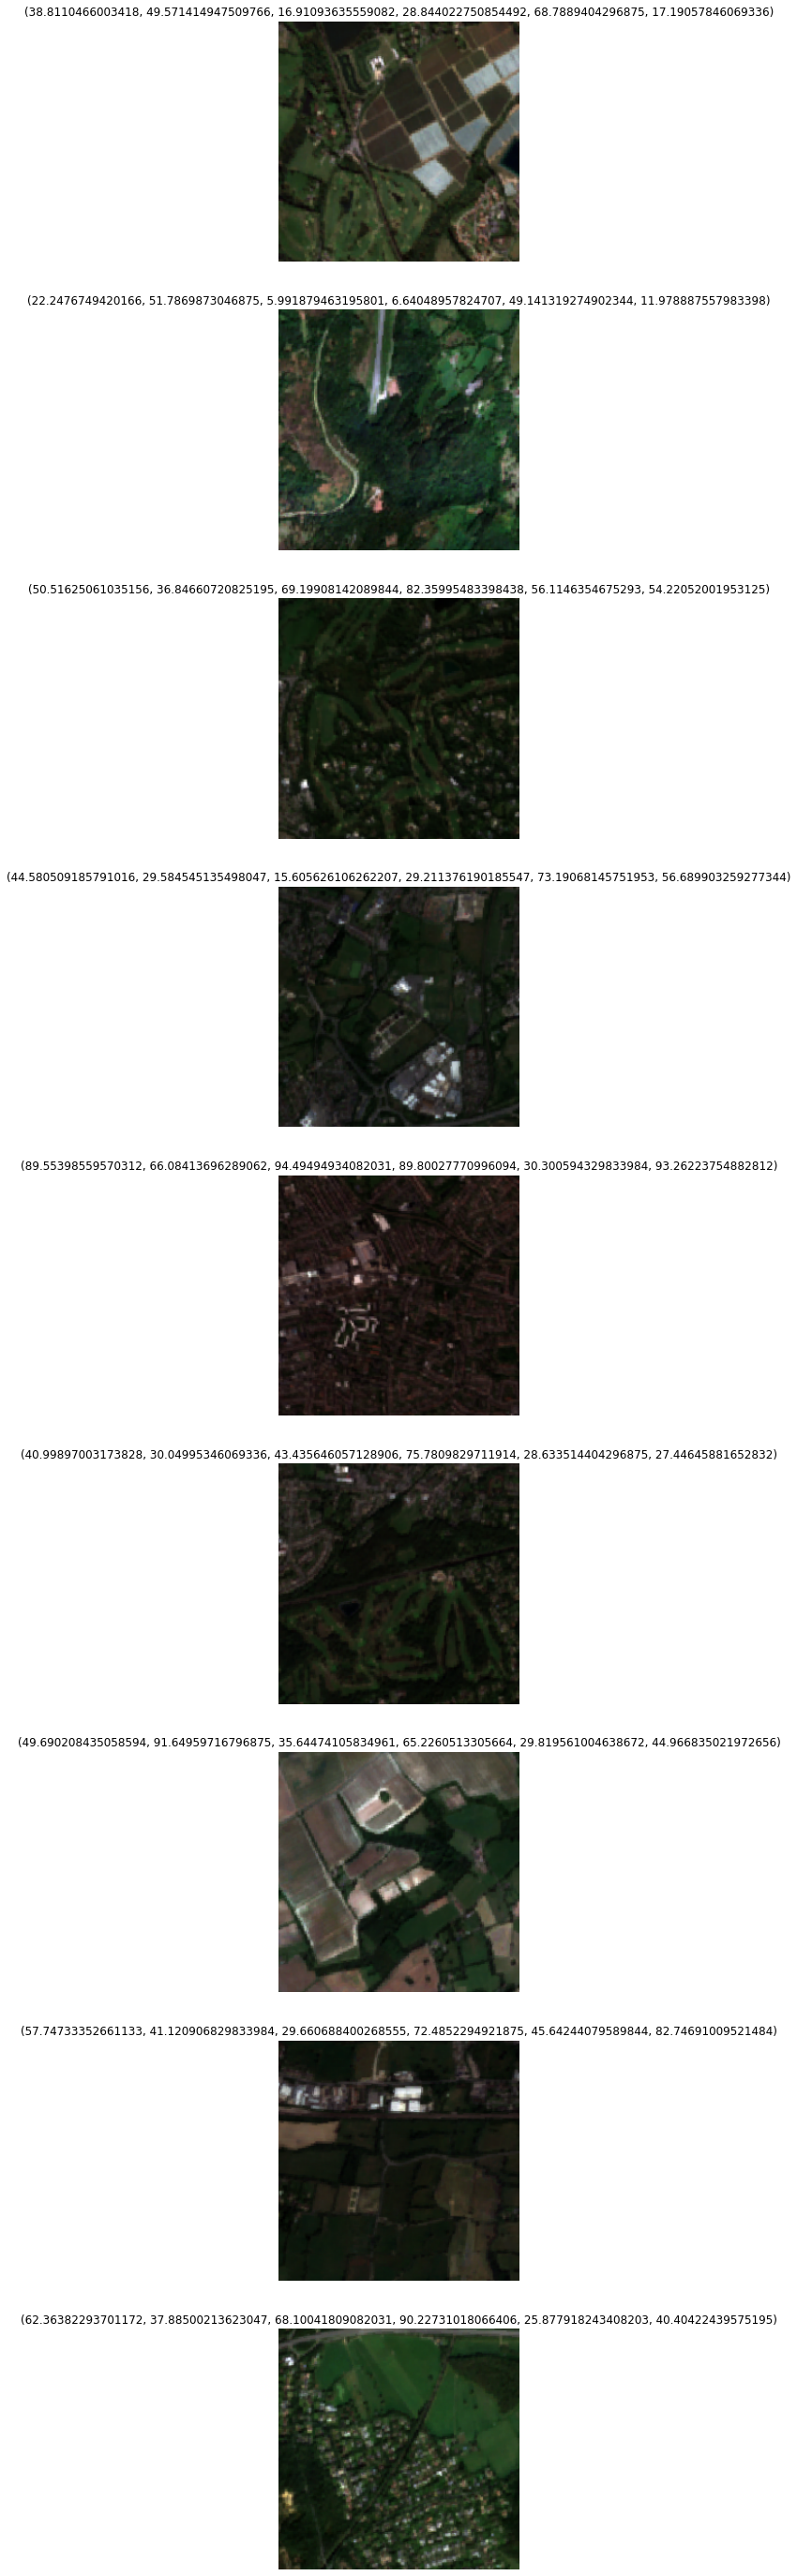

In [19]:
tfm_dl.show_batch(nrows=9, max_n=9, figsize = (50,50))

In [22]:
tfm_block.summary(big_tfm_dir)

Setting-up type transforms pipelines
Found 16974 items
2 datasets of sizes 13580,3394
Setting up Pipeline: PILBase.create
Setting up Pipeline: getGhgsAsArr -> RegressionSetup -- {'c': None}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/drive/MyDrive/img_export/224_png_tfms/r270/hflip/-0.6333122753042627_51.34321006385125.png
    applying PILBase.create gives
      PILImage mode=RGB size=226x224
  Pipeline: getGhgsAsArr -> RegressionSetup -- {'c': None}
    starting from
      /content/drive/MyDrive/img_export/224_png_tfms/r270/hflip/-0.6333122753042627_51.34321006385125.png
    applying getGhgsAsArr gives
      [38.30863716 53.43204174 56.40082985 77.36796669 59.66151051 34.80709298]
    applying RegressionSetup -- {'c': None} gives
      tensor([38.3086, 53.4320, 56.4008, 77.3680, 59.6615, 34.8071])

Final sample: (PILImage mode=RGB size=226x224, tensor([38.3086, 53.4320, 56.4008, 77.3680, 59.6615, 34.8071]))


Found 16974 items
2 datasets of sizes 1

## Training

### Image Recognition and Feature Extraction. 

- Train image-based predictor to guess greenhouse gas concentrations based on 1km square of land. 
  - Transfer an ImageNet predictor to work top-down
  - Start by predicting one ghg and expand from there
- Use image predictor to extract a basic feature set by slicing the network at different points. The idea is to limit the amount of data going into the tabular recommender, while transferring as much useful data as possible. We want to implicitly extract GHG-emitting features of each image without losing any detail, as a form of convolutional preprocessing. 


In [21]:
# uses a regression approach.
# TODO analyse metrics. Really it doesn't seem to matter so long as everything 
#      is evaluated equally, but I'd like to be sure - ask Allan on Monday. 
# TODO Further experimentation with resnet size is necessary. 34 provides _ok_ 
#      predictions, longer is usually better but it takes longer to train. While
#      I'm iterating on design, performance is necessary. Once I'm at a stage 
#      where I can export my model and use it as is, I'll take the time to train 
#      a much larger network. 
learn = cnn_learner(tfm_dl, resnet152, y_range=(0, 100),  metrics=(rmse, mae))

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [23]:
name = "learner test"
learn.save(name)

Path('models/learner test.pth')

In [26]:
learn.load(name)

RuntimeError: ignored

In [24]:
# TODO examine 3d representation of problem space re: local optima 
learn.lr_find()

RuntimeError: ignored

In [ ]:
lr = 0.05
finelr = 0.0019
xfinelr = 0.0007
xxfinelr = 2e-5

In [ ]:
# epochs = 5
learn.fine_tune(1, lr)

epoch,train_loss,valid_loss,_rmse,mae,time
0,328.750092,448.127716,21.169029,16.463821,05:11


epoch,train_loss,valid_loss,_rmse,mae,time
0,281.956696,464.522491,21.552784,17.337582,06:26


In [ ]:
# Saving mid-training, so I can figure out a decent training pathway
learn.save("mid-training")

Path('models/mid-training.pth')

In [ ]:
learn.load("mid-training")

In [ ]:
learn.fine_tune(5, finelr)

In [ ]:
learn.save("fine-tuning")

Path('models/fine-tuning.pth')

In [ ]:
learn.save("fine-tuning-2")

Path('models/fine-tuning-2.pth')

In [ ]:
learn.load("fine-tuning-2")

In [ ]:
learn.fine_tune(5, xfinelr)

epoch,train_loss,valid_loss,_rmse,mae,time
0,203.561386,206.875336,14.383162,11.123506,00:32


epoch,train_loss,valid_loss,_rmse,mae,time
0,199.060699,206.674591,14.376181,11.104246,00:41
1,198.151047,210.320816,14.502441,11.132418,00:41
2,193.575668,208.818680,14.450560,11.105914,00:42
3,191.002472,205.467834,14.334149,11.045927,00:42
4,190.898148,209.903122,14.488033,11.092053,00:43


In [ ]:
learn.save("xfine-tuning")

Path('models/xfine-tuning.pth')

In [ ]:
learn.load("xfine-tuning")

In [ ]:
# at this point, it doesn't seem to make any difference 
# There appears to be a point of diminishing returns, where rmse is just the 
# error rate of the given data. 
learn.fine_tune(10, xxfinelr)

epoch,train_loss,valid_loss,_rmse,time
0,288.068542,279.221527,16.709923,00:32


epoch,train_loss,valid_loss,_rmse,time
0,285.464294,279.312012,16.712629,00:41
1,285.802551,277.339172,16.653503,00:41
2,284.007019,270.917419,16.459570,00:41
3,287.107697,293.174408,17.122337,00:42
4,286.901611,281.448608,16.776430,00:42
5,287.473206,290.663391,17.048853,00:42
6,288.565979,285.801483,16.905663,00:43
7,285.638062,278.335052,16.683376,00:43
8,281.902710,286.228973,16.918303,00:43
9,283.461609,281.155426,16.767691,00:43


### Evaluate Model Performance 

#### Plot results 

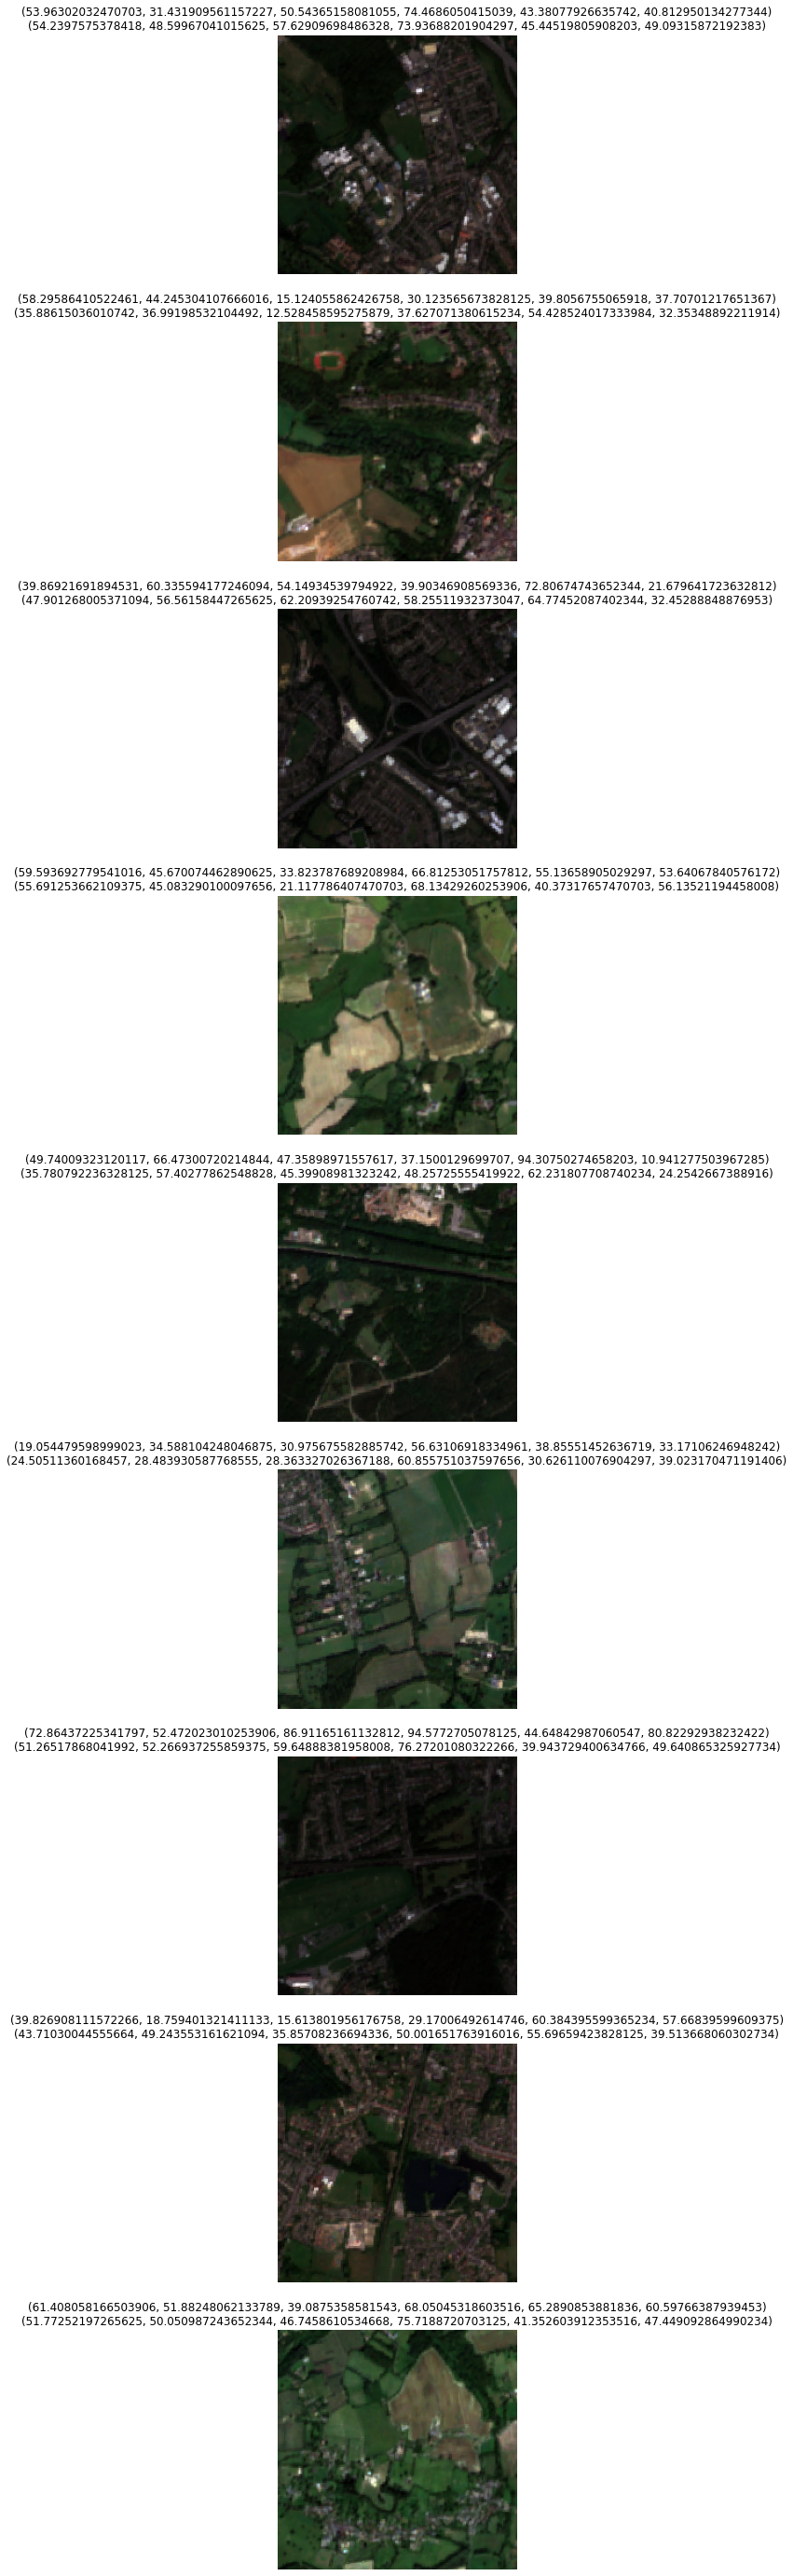

In [ ]:
learn.show_results(ds_idx=1, nrows=9, max_n=9, figsize = (50,50))

In [ ]:
interp = Interpretation.from_learner(learn)

#### Plot model statistics 

### Export the model

In [ ]:
# Export model so we can use it for other things
# Note - this kills the model 
new_model = "mrghg_200221_opts"
learn.export(f"{c.model_dir}/{new_model}.pkl")

In [ ]:
# Import model and test to see if it hasn't broken in the export process. I have
# no idea if this'll happen, but it's worth testing. 
imported_learner = load_learner(f"{c.model_dir}/{c.model_name}.pkl")

In [ ]:
# Predict from imported learner
imported_learner.predict(f"{c.png_dir}/-0.73212695655741_51.2533785354393.png")

((3.3061301708221436,
  6.372119903564453,
  5.765547275543213,
  1.3745146989822388,
  3.039674997329712,
  1.802012324333191),
 tensor([3.3061, 6.3721, 5.7655, 1.3745, 3.0397, 1.8020]),
 tensor([3.3061, 6.3721, 5.7655, 1.3745, 3.0397, 1.8020]))

#### Notes on Image Predictions

A lower learning rate appears to cause slower training with more sophisticated conclusions. Sophistication also appears to arise from a deeper network, but I'm hitting a wall at roughly 0.6 rmse.

---

Currently, the networks are having some trouble defining more subtle characteristics of the images, which shows some flaws in my work. The network will need some supplemental information to accurately predict the greenhouse gas at this point. This may include the following:
- **Latitude/Longitude.** Geography may affect predictions - all the images in my current dataset are near London, meaning they have far more greenhouse gases than most places. To encode a knowledge of city geography into a neural net may take some work...
- **Property Value.** How valuable is this land? This could go some way to encoding city dynamics, as well as explaining where the land might be. If land is rural, but valuable, it's likely to be near major cities or airports. 
- **Nearby GHG Values.** Combined with wind direction, an understanding of source & direction of airflow may describe how areas inherit ghg's from elsewhere. An example of this would be the high concentration of NO<sub>2</sub> north of Heathrow Airport, which may be caused by common flight patterns heading north. 
- **Wind Direction.** See above. 
- **Land Use.** Depending on detail, this may help alleviate the "grey field/massive factory" issue described in my log. By proving that certain areas are rural, residential, or industrial, we can limit errors based on inferring purely visual information. If we can specifically define what a large grey box is doing, we can also come to more developed conclusions about its purpose. A recycling center, an oil refinery, and a brewery may all look similar from above, but information about what they _are_ will limit a neural network getting confused. 
- **Population Density/Economic Output.** This will work in a similar way to property value, where we can predict human activity and its effects on greenhouse gases. Economic output may have a complex relationship to GHG emissions that cannot be easily represented, depending on the form of industry. For example, an eco-tourist attraction may rely on its low carbon footprint for survival, whereas a petrol station relies on high carbon ouput. 
- **Land Height**

Effectively, this network recognises certain features of high-GHG land. Depending on sophistication, this may include airports, power plants, or other rare features, as well as recognising different types of wilderness or residential districts. This will be used to extract a feature set for a tabular recommender, which can then be used to find more accurate readings. 

### Tabular Recommender Training